In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import savetxt
from scipy.ndimage.interpolation import shift

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, AveragePooling1D, SimpleRNN, LSTM


In [2]:
#Loading data from PC- data:full original vector of solar irradiance 
data = pd.read_csv("solar_30min.csv", names=['irradiance'])
print(data.head())

   irradiance
0       0.000
1      10.065
2      46.785
3      97.420
4     239.070


In [3]:
data = data.values
print("Shape of data is ", data.shape)

Shape of data is  (9000, 1)


In [4]:
sigma = np.std(data)
mu = np.mean(data)
datanorm = (data-mu)/sigma

The shape of datamat is  (360, 25)


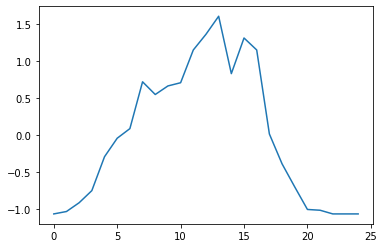

In [5]:
#Random shuffling to matrix across rows
datamat = data.reshape(360,-1)
print("The shape of datamat is ", datamat.shape)
datamat_norm = datanorm.reshape(360,-1)
plt.plot(datamat_norm[0])
datanorm = datamat_norm.reshape(-1,1)

In [6]:
#Function to Split into input ouput sets
def split_seq(seq, n_steps):
    X, y = list(), list()
    for i in range(len(seq)):
    
        #Find end of seq
        end_ix = i+n_steps
        #Check if sequence passed
        if end_ix>len(seq)-1:
            break

        #Gather input and ouputs
        seq_x, seq_y = seq[i:end_ix], seq[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
n_steps = 4
trainval = 25*256 - 5

unk,y_recon = split_seq(datanorm, n_steps)
y_recon = y_recon[trainval :-1]

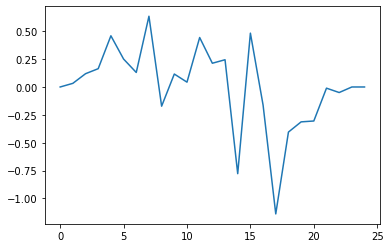

In [8]:
data_diff = datanorm-np.roll(datanorm,1)
plt.plot(data_diff[0:25])

In [9]:
#Training, Testing data split
trainval = 25*256 - 4
trainX_diff = data_diff[0:trainval]
testX_diff = data_diff[trainval:]

In [10]:
n_steps = 4
n_features = 1

#Split into inputs, outputs for training data
Xdiff_train, Ydiff_train= split_seq(trainX_diff, n_steps)

Xdiff_train = Xdiff_train.reshape(Xdiff_train.shape[0],Xdiff_train.shape[1], n_features)

#Split into input and outputs for test data
Xdiff_test, Ydiff_test = split_seq(testX_diff, n_steps)

Xdiff_test = Xdiff_test.reshape(Xdiff_test.shape[0], Xdiff_test.shape[1], n_features)

In [11]:
#Define Model
model = tf.keras.Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps,n_features)))
model.add(AveragePooling1D(pool_size=2))
model.add(Flatten())
# model.add(LSTM(32, activation='tanh', input_shape=(n_steps, n_features), dropout=0.1))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2, 64)             256       
_________________________________________________________________
average_pooling1d (AveragePo (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
______________________________________________________

In [12]:
#Fit model to difference transformed model
hist = model.fit(Xdiff_train, Ydiff_train, epochs=30, batch_size=64, validation_split=0.15, verbose=1, shuffle=False)

Train on 5433 samples, validate on 959 samples
Epoch 1/30
5433/5433 [==============================] - 2s 315us/sample - loss: 0.3028 - val_loss: 0.2405
Epoch 2/30
5433/5433 [==============================] - 1s 98us/sample - loss: 0.2839 - val_loss: 0.2328
Epoch 3/30
5433/5433 [==============================] - 1s 95us/sample - loss: 0.2784 - val_loss: 0.2276
Epoch 4/30
5433/5433 [==============================] - 0s 92us/sample - loss: 0.2749 - val_loss: 0.2251
Epoch 5/30
5433/5433 [==============================] - 1s 97us/sample - loss: 0.2725 - val_loss: 0.2235
Epoch 6/30
5433/5433 [==============================] - 1s 96us/sample - loss: 0.2706 - val_loss: 0.2231
Epoch 7/30
5433/5433 [==============================] - 1s 103us/sample - loss: 0.2688 - val_loss: 0.2220
Epoch 8/30
5433/5433 [==============================] - 1s 102us/sample - loss: 0.2676 - val_loss: 0.2212
Epoch 9/30
5433/5433 [==============================] - 1s 100us/sample - loss: 0.2659 - val_loss: 0.2208
Epoc

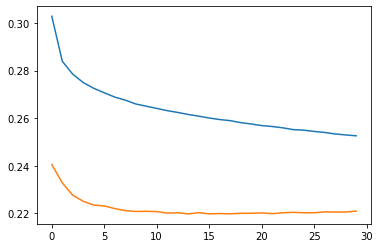

In [13]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='Cross validation')

In [14]:
#Predicting difference transformed data using NN model
yhat_difftest = model.predict(Xdiff_test, verbose=0)

In [15]:
ypred = (yhat_difftest + y_recon)*sigma +mu
yact = (Ydiff_test + y_recon)*sigma +mu

In [16]:
print("Shape of Ydiff_test is ", Ydiff_test.shape)
print("Shape of y_recon is ", y_recon.shape)

Shape of Ydiff_test is  (2600, 1)
Shape of y_recon is  (2600, 1)


In [17]:
RMSE = np.sqrt(sum((ypred-yact)**2)/len(ypred))
print("RMSE is",RMSE )
RMSEpred = np.sqrt(sum((yhat_difftest-Ydiff_test)**2)/len(Ydiff_test))
print("RMSE of prediction is", RMSEpred)

RMSE is [165.90210225]
RMSE of prediction is [0.53789734]


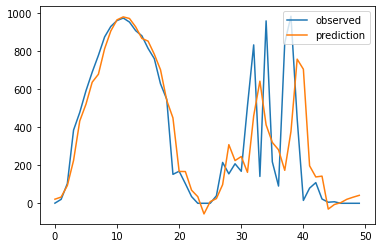

In [18]:
plt.plot(yact[0:50], label='observed')
plt.plot(ypred[0:50], label='prediction')
plt.legend(loc='upper right')

In [19]:
#Make DataFrame
yout = np.hstack((yact, ypred))
yout = pd.DataFrame(list(yout), columns=['Observed','Predicted'])
yout.head()

,Observed,Predicted
0,0.670,21.516296
1,20.725,32.779900
2,103.770,93.443008
3,385.490,225.464929
4,478.680,433.735443


In [20]:
#Save DataFrame to csv
yout.to_csv('CNN_30min.csv', index=False)